# Simple image classifier for Tom & Jerry images
## Summary


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torchinfo import summary
from model import Classifier

In [ ]:
model = Classifier(num_classes=4)
summary(model=model, input_size=(1, 3, 227, 227))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [1, 4]                    --
├─Sequential: 1-1                        [1, 4]                    --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 256, 27, 27]          409,856
│    └─ReLU: 2-5                         [1, 256, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 256, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          885,120
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 384, 13, 13]          1,327,488
│    └─ReLU: 2-10                        [1, 384, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]       

In [ ]:
# load metrics
data = np.load("metrics.npz")
train_losses = data['train_losses']
train_accuracies = data['train_accuracies']

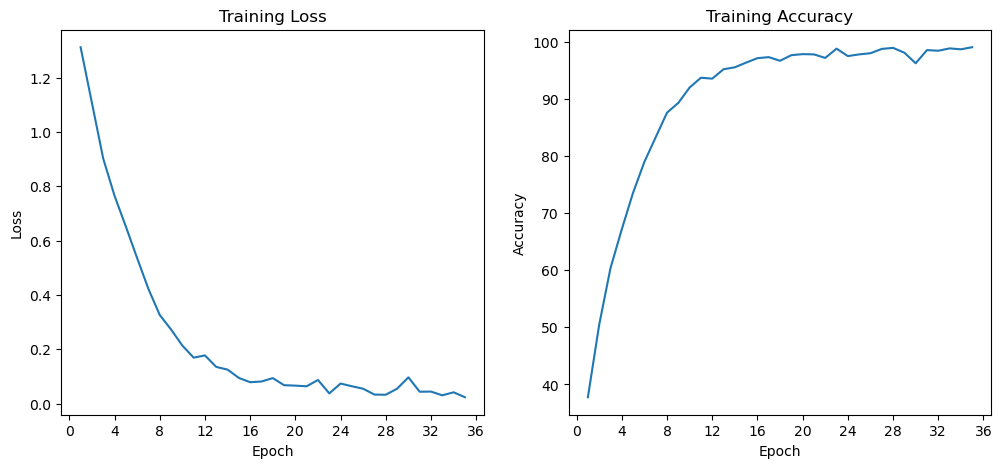

In [ ]:
epoch = [i + 1 for i in range(35)]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss
axes[0].plot(epoch, train_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plot accuracy
axes[1].plot(epoch, train_accuracies)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()